In [1]:
import pandas as pd
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from utils import read_from_zip

In [4]:
data_folder = Path('data')
train_zip = 'train.zip'
test_zip = 'test.zip'

In [5]:
train = read_from_zip(data_folder.joinpath(train_zip))
test = read_from_zip(data_folder.joinpath(test_zip))

In [6]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


Lets explore our dataset

In [8]:
print('Number of training examples: %s\n Number of testing examples: %s' %(len(train), len(test)))

Number of training examples: 19579
 Number of testing examples: 8392


In [9]:
print('Author   Examples\n', train['author'].value_counts())

Author   Examples
 EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


# Word Frequency
Lets get word frequency for each of the author and all the text used.

In [10]:
import nltk

In [11]:
# split the data by author
byAuthor = train.groupby("author")

### Tokenize (split into individual words) our text

# word frequency by author
wordFreqByAuthor = nltk.probability.ConditionalFreqDist()
textByAuthor = {}

print('Author | Unique Tokens')
# for each author...
for author, group in byAuthor:
    # get all of the sentences they wrote and collapse them into a
    # single long string
    sentences = group['text'].str.cat(sep = ' ')
    
    # convert everything to lower case (so "The" and "the" get counted as the same word rather than two different words)
    sentences = sentences.lower()
    
    # split the text into individual tokens
    tokens = nltk.tokenize.word_tokenize(sentences)
    
    # calculate the frequency of each token
    frequency = nltk.FreqDist(tokens)
    
    # add the frequencies for each author to our dictionary
    wordFreqByAuthor[author] = frequency
    textByAuthor[author] = sentences
    
    print(author, '   | {:6}'.format(len(frequency)))
    
# now we have a dictionary where each entry is the frequency distrobution
# of words for a specific author.     

Author | Unique Tokens
EAP    |  15501
HPL    |  14539
MWS    |  11586


In [12]:
# Print most frequent words for any author (change the key: 'EAP')
wordFreqByAuthor['EAP'].most_common(10)

[(',', 17594),
 ('the', 14969),
 ('of', 8970),
 ('.', 7655),
 ('and', 5733),
 ('to', 4761),
 ('a', 4711),
 ('in', 4124),
 ('i', 3780),
 ('that', 2327)]

In [13]:
## Lets check for frequency of word in the writings of diffenret authors
word = 'horror'
for author in wordFreqByAuthor.keys():
    print(author, ': ', wordFreqByAuthor[author].freq(word))

EAP :  0.00023260221575147747
HPL :  0.0005286232237972385
MWS :  0.0002753901802216891


# Word Cloud
Lets generate Word Cloud of the raw text just to visualize the frequent words by each author.

In [14]:
from wordcloud import WordCloud, STOPWORDS

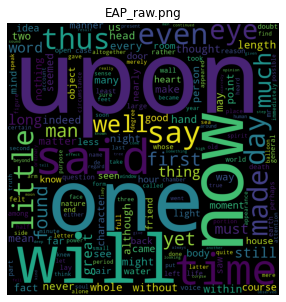

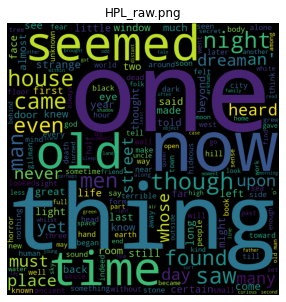

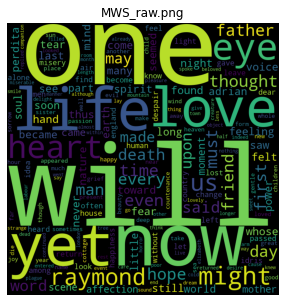

In [15]:
def plot_wordcloud(text, file):
    plt.figure(figsize=(5,5))
    wc = WordCloud(background_color="black", max_words=200, width=800, height=800, random_state=1).generate(text)
    plt.axis('off')
    plt.title(file)
    plt.imshow(wc)
    wc.to_file("images\\"+ file)
    
for author, text in textByAuthor.items():
    plot_wordcloud(text, author + '_raw.png')
    
# Note that the wordcloud library ommits StopWords while plotting this.
# print('ignored stopwords: ', STOPWORDS)

# (Basic) Word frequency model

In [20]:
# One way to guess authorship is to use the joint probabilty that each 
# author used each word in a given sentence.

# first, let's start with a test sentence
testSentence = "It was a dark and stormy night."

def getWordFreqByAuthor(testSentence, wordFreqByAuthor):
    """
    Given a sentence and wordFreqByAuthor it returns a dataframe with probability (freq)
    of each word being used by an author.
    """
    # lowercase & tokenize our test sentence
    preProcessedTestSentence = nltk.tokenize.word_tokenize(testSentence.lower())

    # create an empy dataframe to put our output in
    testProbailities = pd.DataFrame(columns = ['author', 'word', 'probability'])

    # For each author...
    for i in wordFreqByAuthor.keys():
        # for each word in our test sentence...
        for j  in preProcessedTestSentence:
            # find out how frequently the author used that word
            wordFreq = wordFreqByAuthor[i].freq(j)
            # and add a very small amount to every prob. so none of them are 0
            smoothedWordFreq = wordFreq + 0.000001
            # add the author, word and smoothed freq. to our dataframe
            output = pd.DataFrame([[i, j, smoothedWordFreq]], columns = ['author','word','probability'])
            testProbailities = testProbailities.append(output, ignore_index = True)
        
    return testProbailities

def predict_author(testSentence, wordFreqByAuthor=wordFreqByAuthor):
    # Get probabilty of each word (token) for author
    testProbailities = getWordFreqByAuthor(testSentence, wordFreqByAuthor)
    
    # now let's group the dataframe with our frequency by author
    testProbailitiesByAuthor = testProbailities.groupby('author')['probability'].agg('prod')
#     print('Predicted Author: ', testProbailitiesByAuthor.idxmax())
    return testProbailitiesByAuthor.idxmax()

# Note: Above two lines are quivalent to the below lines

# # empty dataframe for the probability that each author wrote the sentence
# testProbailitiesByAuthor = pd.DataFrame(columns = ['author','jointProbability'])

# for i in wordFreqByAuthor.keys():
#     # get the joint probability that each author wrote each word
#     oneAuthor = testProbailities.query('author == "' + i + '"')
#     jointProbability = oneAuthor.product(numeric_only = True)[0]
    
#     # and add that to our dataframe
#     output = pd.DataFrame([[i, jointProbability]], columns = ['author','jointProbability'])
#     testProbailitiesByAuthor = testProbailitiesByAuthor.append(output, ignore_index = True)

# # and our winner is...
# print('Predicted Author: ', testProbailitiesByAuthor.loc[testProbailitiesByAuthor['jointProbability'].idxmax(),'author'])

In [17]:
predict_author(testSentence=testSentence, wordFreqByAuthor=wordFreqByAuthor)

'HPL'

# Base Model : No model
I am submitting a dummy output which gives the same weightage to all the author for all the test data.

In [2]:
test['EAP'] = 1/3
test['HPL'] = 1/3
test['MWS'] = 1/3
test[['id', 'EAP', 'HPL', 'MWS']].to_csv('submissions/noModel.csv', index=False)

The above model will give you log_loss = log(1/3)(base e) ~ 1.09